<a href="https://colab.research.google.com/github/Cesdata/Home-Value-Forecasting/blob/main/ML_Regr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv

In [ ]:
# Iniciando...

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.8 MB/s eta 0:00:00


In [29]:
housing = pd.read_csv('https://raw.githubusercontent.com/Cesdata/Home-Value-Forecasting/refs/heads/main/house_prices.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Verificação de dados faltantes para excluir colunas se preciso

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# percentual de missing

housing.isnull().mean() * 100

,0
Id,0.000000
MSSubClass,0.000000
MSZoning,0.000000
LotFrontage,17.739726
LotArea,0.000000
...,...
MoSold,0.000000
YrSold,0.000000
SaleType,0.000000
SaleCondition,0.000000


In [ ]:
# Verificar e excluir colonas com missing acima de 30%

missing = housing.isnull().mean() * 100
cols_to_drop = missing[missing > 30].index.tolist()
housing.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
# Dropando o target (e ID)

X = housing.drop(columns = ['SalePrice','Id'])
y = housing['SalePrice']

In [ ]:
# Separando em treino e teste

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# Organizando features em numéricas e categóricas

num_features = X_train.select_dtypes(include='number').columns
cat_features = X_train.select_dtypes(include='object').columns

In [ ]:
# Pipeline Corrigido

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor # Adicionado RF
from sklearn.feature_selection import RFE # Adicionado RFE
from category_encoders import CatBoostEncoder

# Pipeline Numérico
num_pipeline = Pipeline([
    ('imputernum', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline Categórico
cat_pipeline = Pipeline([
    ('imputercat', SimpleImputer(strategy='most_frequent')),
    ('encoder', CatBoostEncoder())
])

# Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
      ('numtransf', num_pipeline, num_features),
      ('cattransf', cat_pipeline, cat_features)
    ]
)

# Pipeline Final
pipe = Pipeline([
    ('preprocessor', preprocessor),
    # verificando se tirar 40 features melhora o modelo
    # processo pesado por rodar cada árvore para verificar a feature menos importante
    # PRINCIPAL PONTO
    ('rfe', RFE(RandomForestRegressor(n_estimators=50), n_features_to_select=40)),
    ('regressor', GradientBoostingRegressor())
])

In [ ]:
# Treinar o modelo

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numtransf',
                                                  Pipeline(steps=[('imputernum',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2nd...
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('rfe',
                 RFE(estimator=RandomForestRegressor(n_estimators=50),
                     n_features_to_select=40)),
                ('regressor', GradientBoostingRegressor())])

In [ ]:
# Métricas de erro
# Melhorou o erro 'MAPE' 11 para 9%

y_pred = pipe.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 15669.66541246091
Mean Absolute Percentage Error (MAPE): 9.140168439888319
Mean Squared Error (MSE): 672951050.3612494
Root Mean Squared Error (RMSE): 25941.30009003499


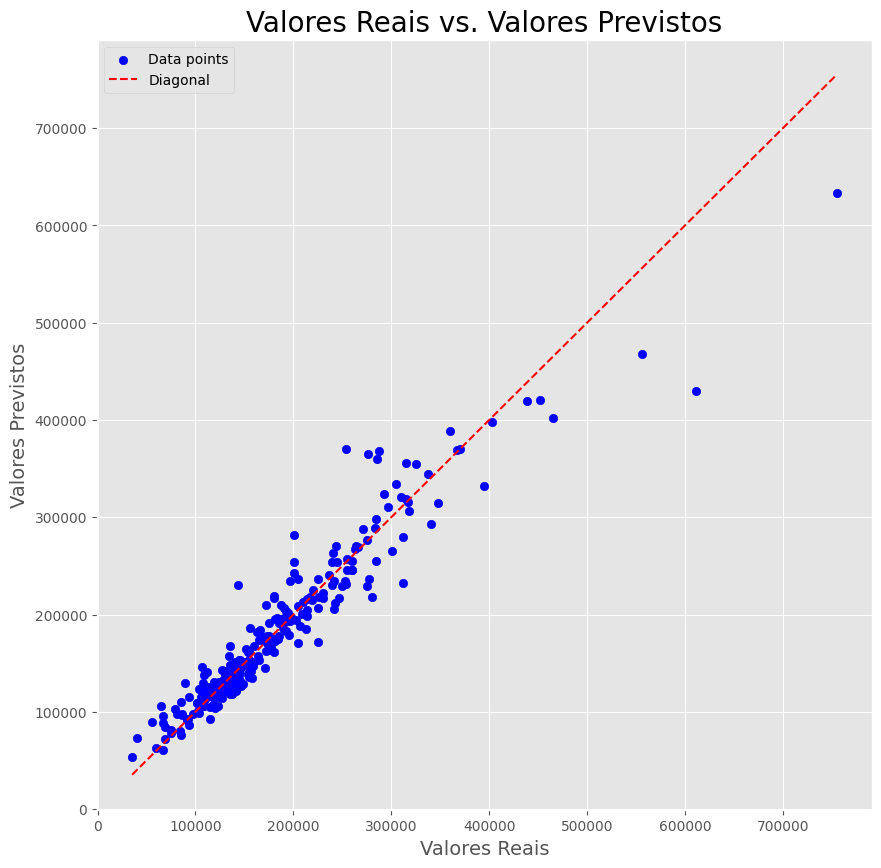

In [ ]:
# Gráfico do que realmente aconteceu vs. o que o modelo previu
# O ideal seria uma diagonal com ângulo de 45º

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')

plt.scatter(y_test, y_pred, c ='blue', label = 'Data points')

plt.xlabel('Valores Reais', fontsize=14)
plt.ylabel('Valores Previstos', fontsize=14)
plt.title('Valores Reais vs. Valores Previstos', fontsize=20)

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Diagonal')

plt.legend()

